# Ultrasound segmentation examples

Example script for some segmentation tasks currently supported by the `zea` library.



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/models/segmentation_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/models/segmentation_example.ipynb)
&nbsp;
[![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/zeahub/echonet-dynamic)

In [ ]:
%%capture
%pip install zea

In [ ]:
import os

# NOTE: should be `tensorflow` or `jax` for EchoNetDynamic
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
import matplotlib.pyplot as plt
from keras import ops
from PIL import Image
import numpy as np
import requests
from io import BytesIO

from zea import init_device, log
from zea.backend.tensorflow.dataloader import make_dataloader
from zea.tools.selection_tool import add_shape_from_mask
from zea.utils import translate
from zea.visualize import plot_image_grid, set_mpl_style

zea: Using backend 'tensorflow'


In [3]:
init_device(verbose=False)
set_mpl_style()

## Left ventricle segmentation

Here we use the [EchoNetDynamic](https://echonet.github.io/dynamic/) model within the zea framework to segment left ventricle in echocardiograms. Note that in this notebook, we use the original model, but perform inference on the [CAMUS](https://www.creatis.insa-lyon.fr/Challenge/camus/) dataset, which is a different dataset than the one used to train the model.

In [4]:
from zea.models.echonet import EchoNetDynamic, INFERENCE_SIZE

presets = list(EchoNetDynamic.presets.keys())
log.info(f"Available built-in zea presets for EchoNetDynamic: {presets}")

model = EchoNetDynamic.from_preset("echonet-dynamic")

zea: Available built-in zea presets for EchoNetDynamic: ['echonet-dynamic']


Now let's load some data (for more info see the [zea_data_example](../data/zea_data_example.ipynb) notebook), and perform inference on the data to segment the left ventricle. Note that the performance of the model is not as good on the CAMUS dataset as it is on the original EchoNetDynamic dataset, but it still provides a good example of how to use the model within the zea framework.

zea: Using pregenerated dataset info file: /home/devcontainer0/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /home/devcontainer0/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on June 08, 2025
zea: Remove /home/devcontainer0/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.
zea: WARNING H5Generator: Not all files have the same shape. This can lead to issues when resizing images later....
zea: H5Generator: Shuffled data.
zea: H5Generator: Shuffled data.


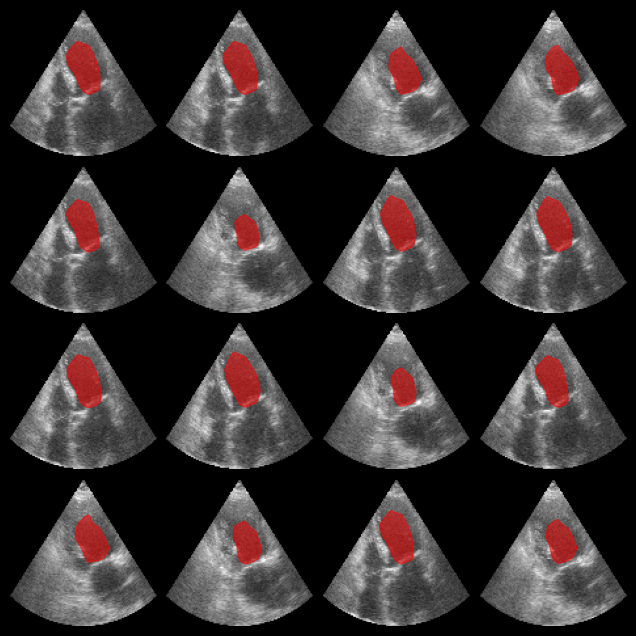

In [5]:
n_imgs = 16
val_dataset = make_dataloader(
    "hf://zeahub/camus-sample/val",
    key="data/image_sc",
    batch_size=n_imgs,
    shuffle=True,
    image_range=[-60, 0],
    normalization_range=[-1, 1],
    image_size=(INFERENCE_SIZE, INFERENCE_SIZE),
    resize_type="resize",
    seed=42,
)

batch = next(iter(val_dataset))
# grayscale to RGB for the EchoNetDynamic model
rgb_batch = ops.concatenate([batch, batch, batch], axis=-1)

masks = model(rgb_batch)
masks = ops.squeeze(masks, axis=-1)
masks = ops.convert_to_numpy(masks)

batch = translate(rgb_batch, [-1, 1], [0, 1])
fig, _ = plot_image_grid(batch, vmin=0, vmax=1)
axes = fig.axes[:n_imgs]
for ax, mask in zip(axes, masks):
    add_shape_from_mask(ax, mask, color="red", alpha=0.5)

plt.show()

## Carotid artery segmentation
This section demonstrates how to use the `CarotidSegmenter` model from the `zea` library to segment the carotid artery in ultrasound images. The model predicts a mask highlighting the carotid region for a given input image.

For more details, see the [original paper](https://doi.org/10.1016/j.cmpb.2022.107037):  
- Luuk van Knippenberg, "Unsupervised domain adaptation method for segmenting cross-sectional CCA images", Computers in Biology and Medicine, 2022.

In [6]:
from zea.models.carotid_segmenter import CarotidSegmenter

presets = list(CarotidSegmenter.presets.keys())
log.info(f"Available built-in zea presets for CarotidSegmenter: {presets}")

model = CarotidSegmenter.from_preset("carotid-segmenter")

zea: Available built-in zea presets for CarotidSegmenter: ['carotid-segmenter']


config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

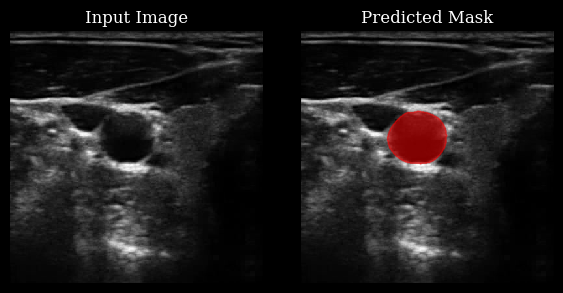

In [ ]:
n_imgs = 1
url = "https://raw.githubusercontent.com/tue-bmd/zea/main/docs/source/notebooks/assets/carotid.png"

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("L")
img_np = np.asarray(img).astype(np.float32) / 255.0

img_np = img_np[None, ..., None]  # add batch and channel dimensions
batch = ops.convert_to_tensor(img_np)

masks = model(batch)
masks = ops.squeeze(masks, axis=-1)
masks_clipped = ops.where(masks > 0.5, 1, 0)
masks_clipped = ops.convert_to_numpy(masks_clipped)

# stack batch twice to get 2 rows
batch_stacked = ops.concatenate([batch, batch])

# Plot the original image and its mask side by side, with each row as an example
fig, axes = plt.subplots(n_imgs, 2, figsize=(6, 3 * n_imgs))
axes = np.atleast_2d(axes)

for ax_img, ax_mask, img_arr, mask_arr in zip(axes[:, 0], axes[:, 1], batch[..., 0], masks_clipped):
    ax_img.imshow(img_arr, cmap="gray", vmin=0, vmax=1)
    ax_img.set_title("Input Image")
    ax_img.axis("off")
    ax_mask.imshow(img_arr, cmap="gray", vmin=0, vmax=1)
    add_shape_from_mask(ax_mask, mask_arr, color="red", alpha=0.5)
    ax_mask.set_title("Predicted Mask")
    ax_mask.axis("off")

plt.tight_layout()
plt.show()